# 不同积分方法对 HH 模型神经元动态的影响

本实例将通过实现经典的 Hodgkin-Huxley 模型，对比指数欧拉法 ``exp_euler`` 和独立指数欧拉法 ``ind_exp_euler`` 对神经元膜电位动态的影响。
你将学习如何在 `braincell` 中配置不同的积分器，以及它们在模拟神经元电活动时的差异。

## 准备工作

首先确保已安装必要的库（`braincell`、`brainstate`、`brainunit`、`matplotlib`），并导入所需模块：

In [7]:
import brainstate
import brainunit as u
import matplotlib.pyplot as plt
import braincell

## 代码详解

### 定义 HH 模型神经元

使用 `SingleCompartment` 构建基于 HH 模型的单神经元，包含钠通道 `INa` 、钾通道 `IK` 和漏电流 `IL` ，这些通道共同决定神经元的放电特性：

In [8]:
class HH(braincell.SingleCompartment):
    def __init__(self, size, solver='rk4'):
        super().__init__(size, solver=solver)

        self.na = braincell.ion.SodiumFixed(size, E=50. * u.mV)
        self.na.add(INa=braincell.channel.INa_HH1952(size))

        self.k = braincell.ion.PotassiumFixed(size, E=-77. * u.mV)
        self.k.add(IK=braincell.channel.IK_HH1952(size))

        self.IL = braincell.channel.IL(
            size,
            E=-54.387 * u.mV,
            g_max=0.03 * (u.mS / u.cm **2)
        )

### 初始化神经元与配置积分方法

创建两个 HH 神经元实例，分别使用标准指数欧拉法 ``exp_euler``和独立指数欧拉法 ``ind_exp_euler``，并初始化神经元状态：

In [9]:
# 创建使用标准指数欧拉法的 HH 神经元
hh_exp = HH(1, solver='exp_euler')

# 创建使用独立指数欧拉法的 HH 神经元
hh_ind_exp = HH(1, solver='ind_exp_euler')

# 初始化神经元状态（如膜电位、门控变量等）至静息状态
hh_exp.init_state()
hh_ind_exp.init_state()

### 定义模拟步骤函数

编写函数描述神经元在每个时间步的更新规则，包括接收输入电流并返回膜电位：

In [10]:
def step_fun(t, neuron):
    # 在当前时间 t 下更新神经元状态
    with brainstate.environ.context(t=t):
        # 向神经元注入持续电流以触发动作电位
        neuron.update(10 * u.nA / u.cm** 2)
    # 返回当前膜电位值
    return neuron.V.value

### 运行模拟并记录结果

配置模拟参数，分别运行两种积分方法的模拟，记录膜电位随时间的变化：

In [11]:
# 设置模拟时间步长
with brainstate.environ.context(dt=0.1 * u.ms):
    # 生成模拟时间序列
    times = u.math.arange(0. * u.ms, 100 * u.ms, brainstate.environ.get_dt())

    # 用标准指数欧拉法模拟，记录膜电位
    vs_exp = brainstate.transform.for_loop(
        lambda t: step_fun(t, hh_exp),
        times
    )

    # 用独立指数欧拉法模拟，记录膜电位
    vs_ind_exp = brainstate.transform.for_loop(
        lambda t: step_fun(t, hh_ind_exp),
        times
    )

### 可视化膜电位动态

绘制两种积分方法下的膜电位变化曲线，对比动作电位波形差异：

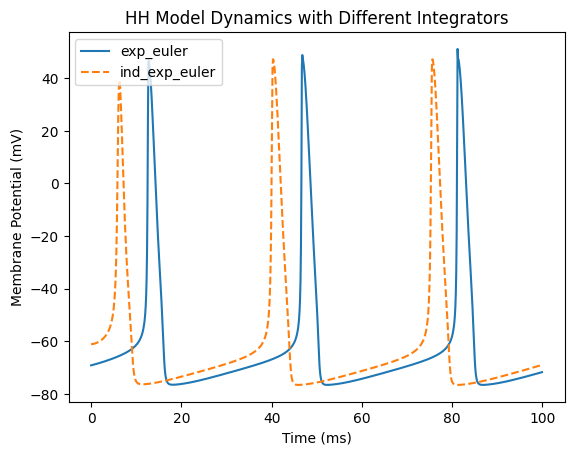

In [12]:
# 绘制标准指数欧拉法的结果
plt.plot(times, u.math.squeeze(vs_exp), label='exp_euler', linewidth=1.5)

# 绘制独立指数欧拉法的结果
plt.plot(times, u.math.squeeze(vs_ind_exp), label='ind_exp_euler', linestyle='--', linewidth=1.5)

# 添加标签和图例
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()
plt.title('HH Model Dynamics with Different Integrators')
plt.show()

## 结果解读

运行代码后，你将看到膜电位随时间变化的曲线。

核心结论如下：
动作电位基本特征：两种方法均能模拟出动作电位的产生，但波形细节存在差异。
积分方法差异：
   - `exp_euler` 曲线更平滑，对强耦合的门控变量与膜电位关系拟合更精确，动作电位峰值和时程更接近理论值。
   - `ind_exp_euler` 由于独立更新状态变量，可能在快速变化阶段出现微小偏差，但计算速度更快，尤其在大规模模拟时。
适用性场景：
   - 对精度要求高的单细胞模拟，如复现特定电生理实验，优先选择 `exp_euler` 。
   - 大规模网络模拟，如包含数千神经元，`ind_exp_euler` 能在保证足够精度的同时显著提升效率。

## 扩展练习

- 尝试使用四阶龙格-库塔法 `solver='rk4'` ，对比其与指数欧拉法的精度和计算效率。
- 调整输入电流强度，观察不同积分方法对神经元发放频率的影响。
- 增加模拟时长，分析长期模拟中积分误差的累积效应。

通过这些实践，你将深入理解数值方法在神经模拟中的关键作用，为复杂模型设计提供依据。

## 更多

若想了解更多的数值积分方法，我们在[数值积分方法库](https://braincell.readthedocs.io/latest/apis/integration.html) 中提供了丰富的积分器与相关资料。